# Trabajo Practico NLP - Detección de Tópicos y clasificación

* Los archivos necesarios para poder correr la aplicación son: **utils.py** (contiene todas las funciones y utilidades que se invocan), **opensearch_data_model.py** (contiene el modelo de datos que se utiliza para la base de datos vectorial), la carpeta **Data** (que contiene los Stopwords) y esta notebook **TP_NLP.ipynb**.

* Todo la ejecución del código se puede hacer desde esta notebook

* Crear un entorno virtual y activarlo

``` bash
conda create -n topics python=3.11
conda activate topics

pip install -r requirements

```

* Levantar el docker con la base de datos vectorial **Opensearch**

docker pull opensearchproject/opensearch:latest  

docker run -it -p 9200:9200 -p 9600:9600 -e OPENSEARCH_INITIAL_ADMIN_PASSWORD=PassWord#1234! -e "discovery.type=single-node" --name opensearch-node opensearchproject/opensearch:latest  

docker start opensearch-node



## Breve descripción del código


* Todo el código se puede ejecutar desde esta notebook, ya que se invocan las funciones desde los archivos complementarios.  
  
  

**INICIALIZACIÓN DE LA BASE DE DATOS VECTORIAL**

* La función ***init_opensearch()*** verifica si estan creados los índices "topic" y "aux" del archivo **opensearch_data_model.py**, y en caso de que no estén creados, los inicializa.  


**CARGA DE NOTICIAS**
* Para cargar un batch de noticias, se utiliza la función  ***procesar_batch_de_noticias()*** , que es la que orquesta secuencialmente todo el proceso. Hay que pasarle la fecha a procesar, y luego se va imprimiendo en consola los distintos estadíos del proceso y sus resultados.


* Se llama a la función ***obtener_news_batch()***, que selecciona aleatoriamente y para el día indicado, 2.000 noticias del repositorio proporcionado en Hugging Face para trabajar.  


**VOCABULARIO PROPIO Y GENERACIÓN DEL MODELO**
* La función ***vocabulario_propio()*** genera un listado con los tokens ("entities" y "keywords") correspondientes al batch de noticias. Este vocabulario es el que se va a utilizar en el CountVectorizer del modelo.

* La función ***generar_modelo()*** genera el modelo de tópicos con BERTopic, a partir de sus partes fundamentales:
Embedding model: SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'), UMAP, HDBSCAN,  CountVectorizer, ClassTfidfTransformer, KeyBERTInspired.

* El modelo se entrena, y se informa la cantidad de tópicos encontrados y sus nombres.  


**MERGE DE TÓPICOS INTRADIARIO**

* La función ***similitudes_entre_topicos()*** se encarga de determinar si entre los tópicos generados por el modelo, existen tópicos para mergear de forma intradiaria. Para lograrlo, se llama a la función ***matriz_cosine_sim_topicos()*** para que calcule una matriz de similitud coseno entre todos los tópicos. Utilizando dicha matriz, compara sus valores contra un umbral predefinido, y en caso de que un par de tópicos lo supere, lo informa y los incluye una lista para ser mergeados.

* Si existen tópicos para ser mergeados de forma intradiaria, se fusionan con la función ***"merge_topics"*** de BERTopic.  


**INSERCIÓN DE TÓPICOS EN BD VECTORIAL**
* Previo a la inserción de los tópicos en la BD vectorial, se utilizan las funciones auxiliares ***matriz_cosine_sim_docs_topicos()*** y ***generar_lista_tresholds()***, para calcular la similitud coseno entre embeddings de tópicos y documentos, y para determinar el treshold de cada tópico con sus documentos. Dicho treshold se calcula como el promedio de la similitud coseno de los documentos con el tópico.

* La función ***insertar_topicos_en_bd_vctorial()*** es la encargada de orquestar la inserción de tópicos en la base de datos vectorial. Se diferencia entre el primer batch de noticias que se inserta y el resto, ya que para el primer batch no hay datos para calcular posibles merge de tópicos con dias previos.

* Para la inserción en la BD, se construye iterativamente un objeto "Topic" o "Aux" (especificado en el modelo de datos del archivo opensearch_Data_model.py) para luego insertarlo en opensearch.

* Tratandose de tópicos posteriores al primer batch, los mismos son insertados de forma provisoria en el índice "aux" de opensearch, para trabajar sobre posibles merge de tópicos entre dias.

* La función ***recuperar_topicos_bd_vectorial()*** se encarga de escanear y devolver todos los tópicos existentes en la BD, y la función ***recuperar_topicos_bd_vectorial_aux()*** devuelve los tópicos del día procesado.  


**MERGE DE TÓPICOS ENTRE DIAS**

* Tal cual se explicó en clase, ante un nuevo batch de noticias, si las mismas generan un tópico que ya existe, en lugar de generar un nuevo tópico, se debe mergear con uno ya existente.

* La función ***merge_entre_dias()*** se encarga de evaluar la existencia de tópicos para mergear entre distintos dias. Para ello, mediante un cálculo de distancia coseno, evalúa los pares de tópicos actuales que superan el umbral pre establecido con tópicos de dias previos. 

* De no superar el umbral, el tópico se inserta en el índice "topic" como en el caso anterior.

* En caso de superar el umbral, se informa el par de tópicos a mergear, y para ellos se calcula el listado final de keywords que tendrá y el embedding del tópico mergeado.

* La fecha de creación del tópico mergeado se indica como la del día que se está procesando el batch de noticias. La fecha ***"from_date"*** conserva la del tópico original, y la fecha ***"to_date"*** asume el valor del día que se está procesando. De esta forma, se puede hacer un tracking de los tópicos vigentes, y desde cuando existen.

* Por último, se procede a vaciar el índice "aux", en* donde estaban alojados provisoriamente los tópicos del batch de noticias que se estaba procesando. Para ello se utiliza la función ***eliminar_topicos_aux()***  


**INFERENCIA PARA UNA NOTICIA RANDOM**

* Para generar una noticia cualquiera, se utiliza la función ***obtener_noticia_aleatoria()***. La misma, va a devolver el título y el texto de una noticia elegida al azar, dentro de las noticias disponibles para la fecha que se pasa como argumento.

* La función ***procesar_nueva_noticia()*** se encarga de calcular su embedding, extraer entidades y keywords mediante "Spacy", y hacer análisis de sentimiento mediante el modelo de Hugging Face ***"nlptown/bert-base-multilingual-uncased-sentiment"***. 

* Mediante un query de tipo búsqueda KNN a la BD vectorial, se devuelven los 5 tópicos más cercanos a la noticia evaluada, y sus keywords relevantes.

### Importación de utilities

In [1]:
from opensearch_data_model import init_opensearch
from utils import obtener_noticia_aleatoria, procesar_batch_de_noticias, procesar_nueva_noticia, topicos_vigentes

c:\Users\rivero.emmanuel\AppData\Local\anaconda3\envs\topics\Lib\site-packages\opensearchpy\connection\http_urllib3.py:199: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(
c:\Users\rivero.emmanuel\AppData\Local\anaconda3\envs\topics\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\rivero.emmanuel\AppData\Local\anaconda3\envs\topics\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Inicialización de BD vectorial

In [2]:
init_opensearch()

Índice Topic creado
Índice Aux creado


### Fechas de noticias para trabajar

In [ ]:
# Hugginface https://huggingface.co/jganzabalseenka
"""
2024-07-17_24hs
2024-07-18_24hs
2024-07-19_24hs
2024-07-20_24hs
2024-07-21_24hs
"""

### PROCESAR BATCH DE NOTICIAS DIA 1

In [3]:

fecha = '2024-07-17'
procesar_batch_de_noticias(fecha=fecha, primer_dia=True)


Se obtuvieron 2000 noticias del día 2024-07-17

Se generaron 30778 tokens de vocabulario propio con noticias del día 2024-07-17


2024-09-01 14:03:41,027 - BERTopic - Embedding - Transforming documents to embeddings.



Modelo de tópicos generado

Entrenando modelo....


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2024-09-01 14:07:08,658 - BERTopic - Embedding - Completed ✓
2024-09-01 14:07:08,660 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 14:07:20,790 - BERTopic - Dimensionality - Completed ✓
2024-09-01 14:07:20,790 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 14:07:20,889 - BERTopic - Cluster - Completed ✓
2024-09-01 14:07:20,904 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 14:07:51,936 - BERTopic - Representation - Completed ✓



Entrenamiento finalizado

Número de tópicos encontrados: 35 (incluye el topico -1)

Labels de los tópicos generados:
['-1_gobierno_ministro_gobernador', '0_argentinos_argentina_argentino', '1_detenidos_cárcel_detención', '2_reforma laboral_reforma_gobierno nacional', '3_jugadores argentinos_argentinos_argentina', '4_juliana furia_furia_mariana', '5_violentos robos_robo ocurrido_violento asalto', '6_consumo masivo_consumo_precios argentinos', '7_incendio forestal_incendios_incendio', '8_contribuyentes argentinos_normativa_reglamentación', '9_calles_caminos_calle', '10_epidemiología_contagios_víctimas menores', '11_rock argentino_estación zafiro_mariana', '12_fuerte accidente_accidente_brutal accidente', '13_punta colombiano_argentina_medina', '14_educación pública_instituciones educativas_personal escolar', '15_mandatario brasileño_mandatario argentino_presidente argentino', '16_expresidente donald trump_presidente donald trump_inteligencia estadounidense', '17_meteorología_temperatura

Dejo una captura parcial (por el tamaño) del Elasticvue

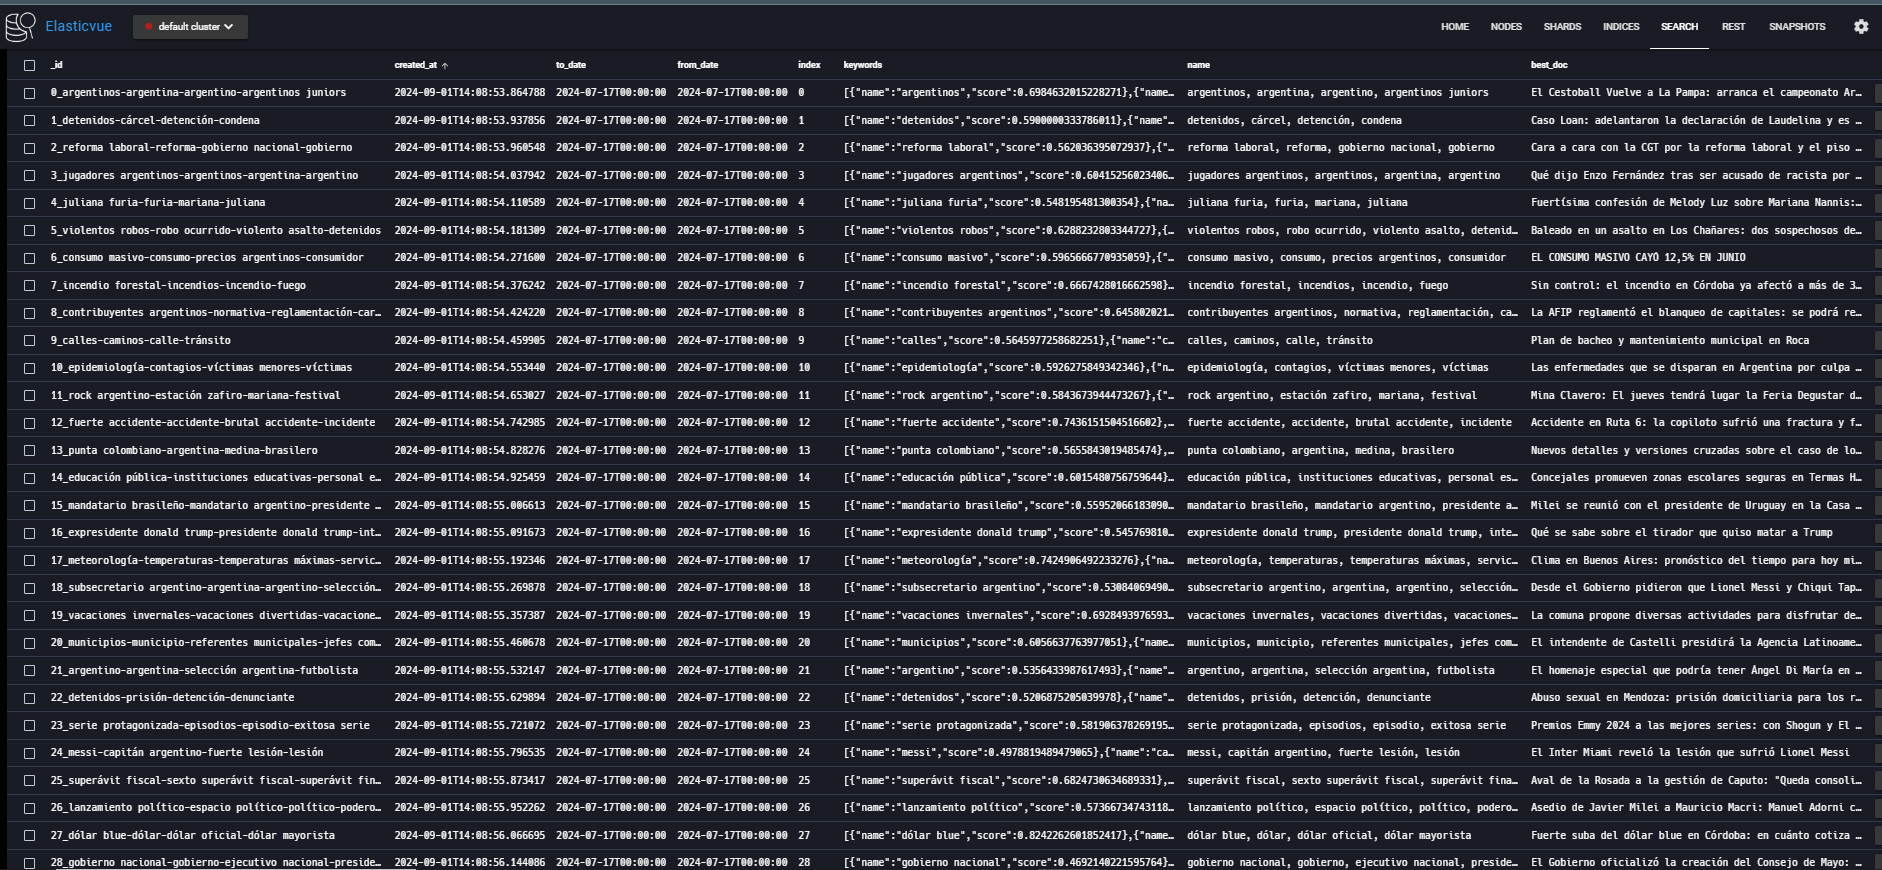

In [4]:
# Ver tópicos vigentes
fecha = '2024-07-17'
df = topicos_vigentes(fecha)
df['_id']

Tópicos vigentes a la fecha 2024-07-17


0     0_argentinos-argentina-argentino-argentinos ju...
1                  1_detenidos-cárcel-detención-condena
2     2_reforma laboral-reforma-gobierno nacional-go...
3     3_jugadores argentinos-argentinos-argentina-ar...
4                 4_juliana furia-furia-mariana-juliana
5     5_violentos robos-robo ocurrido-violento asalt...
6     6_consumo masivo-consumo-precios argentinos-co...
7          7_incendio forestal-incendios-incendio-fuego
8     8_contribuyentes argentinos-normativa-reglamen...
9                       9_calles-caminos-calle-tránsito
10    10_epidemiología-contagios-víctimas menores-ví...
11    11_rock argentino-estación zafiro-mariana-fest...
12    12_fuerte accidente-accidente-brutal accidente...
13       13_punta colombiano-argentina-medina-brasilero
14    14_educación pública-instituciones educativas-...
15    15_mandatario brasileño-mandatario argentino-p...
16    16_expresidente donald trump-presidente donald...
17    17_meteorología-temperaturas-temperaturas 

### PROCESAR BATCH DE NOTICIAS DIA 2

In [5]:
fecha = '2024-07-18'
procesar_batch_de_noticias(fecha=fecha, primer_dia=False)


Se obtuvieron 2000 noticias del día 2024-07-18

Se generaron 30415 tokens de vocabulario propio con noticias del día 2024-07-18


2024-09-01 14:17:16,388 - BERTopic - Embedding - Transforming documents to embeddings.



Modelo de tópicos generado

Entrenando modelo....


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2024-09-01 14:20:37,574 - BERTopic - Embedding - Completed ✓
2024-09-01 14:20:37,574 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 14:20:43,220 - BERTopic - Dimensionality - Completed ✓
2024-09-01 14:20:43,220 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 14:20:43,308 - BERTopic - Cluster - Completed ✓
2024-09-01 14:20:43,314 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 14:21:03,603 - BERTopic - Representation - Completed ✓



Entrenamiento finalizado

Número de tópicos encontrados: 21 (incluye el topico -1)

Labels de los tópicos generados:
['-1_tragedia_com_historia', '0_inflación_economía_actividad económica', '1_selección argentina_argentinos_argentina', '2_historia argentina_atentado_atentado terrorista', '3_vacaciones_actividades recreativas_fiesta nacional', '4_efectivos policiales_policías_policía', '5_argentina_argentino_argentina campeona', '6_ladrón_delincuentes_fuentes policiales', '7_peña_testimonio_macarena peña', '8_vicepresidenta argentina_futbolista argentino_argentinos', '9_asesinato_brutal asesinato_homicidio', '10_fuerte accidente_accidente fatal_grave accidente', '11_mariana_carajo_diva', '12_candidatura presidencial_carrera presidencial_actual presidente', '13_científicos argentinos_restos fosilizados_restos fósiles', '14_sueldo mínimo_salario mínimo_desempleo', '15_servicio meteorológico_altas temperaturas_clima', '16_juliana furia_hermano juliana_contrato', '17_español_cine argentino

### PROCESAR BATCH DE NOTICIAS DIA 3

In [7]:
fecha = '2024-07-19'
procesar_batch_de_noticias(fecha=fecha, primer_dia=False)


Se obtuvieron 2000 noticias del día 2024-07-19

Se generaron 30799 tokens de vocabulario propio con noticias del día 2024-07-19


2024-09-01 14:26:26,543 - BERTopic - Embedding - Transforming documents to embeddings.



Modelo de tópicos generado

Entrenando modelo....


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2024-09-01 14:29:50,139 - BERTopic - Embedding - Completed ✓
2024-09-01 14:29:50,139 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 14:29:55,948 - BERTopic - Dimensionality - Completed ✓
2024-09-01 14:29:55,948 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 14:29:56,018 - BERTopic - Cluster - Completed ✓
2024-09-01 14:29:56,020 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 14:30:22,654 - BERTopic - Representation - Completed ✓



Entrenamiento finalizado

Número de tópicos encontrados: 29 (incluye el topico -1)

Labels de los tópicos generados:
['-1_pesos_plata_fondos', '0_selección argentina_argentina_argentino', '1_banco central_entidades financieras_bancos', '2_festival_vacaciones_turismo', '3_apagón informático_falla informática_fallo informático', '4_cantante argentina_luciano_juliana furia', '5_joven asesinada_presunto asesino_asesino', '6_cocaína_dinero narco_ladrones', '7_obras públicas_municipio_centro provincial', '8_reforma política_voltaje político_reforma electoral', '9_atentado_ataque israelí_organización terrorista', '10_mínimos salariales_desempleo_propuestas salariales', '11_preso_prisión preventiva_detención', '12_pesos emitidos_pesos_esquema monetario', '13_embajador francés_embajada francesa_incidente diplomático', '14_servicio meteorológico_temperaturas_temperaturas mínimas', '15_accidente vial_accidente fatal_terrible accidente', '16_enfermedades_enfermedad_pacientes', '17_episodios_cuart

In [8]:
# Ver tópicos vigentes
fecha = '2024-07-19'
df = topicos_vigentes(fecha)
df['_id']

Tópicos vigentes a la fecha 2024-07-19


0     0_argentinos-argentina-argentino-argentinos ju...
1     1_banco central-entidades financieras-bancos-c...
2     2_vacaciones-actividades recreativas-fiesta na...
3     3_apagón informático-falla informática-fallo i...
4                 4_juliana furia-furia-mariana-juliana
5        5_asesinato-brutal asesinato-homicidio-matanza
6     6_violentos robos-robo ocurrido-violento asalt...
7     7_obras públicas-municipio-centro provincial-s...
8     8_reforma política-voltaje político-reforma el...
9     9_historia argentina-atentado-atentado terrori...
10    10_sueldo mínimo-salario mínimo-desempleo-refo...
11                11_detenidos-cárcel-detención-condena
12    12_pesos emitidos-pesos-esquema monetario-fond...
13    13_embajador francés-embajada francesa-inciden...
14    14_meteorología-temperaturas-temperaturas máxi...
15    15_fuerte accidente-accidente-brutal accidente...
16           16_enfermedades-enfermedad-pacientes-salud
17    17_episodios-cuarta temporada-comedia-obra

### PROCESAR BATCH DE NOTICIAS DIA 4

In [9]:
fecha = '2024-07-20'
procesar_batch_de_noticias(fecha=fecha, primer_dia=False)


Se obtuvieron 2000 noticias del día 2024-07-20

Se generaron 32187 tokens de vocabulario propio con noticias del día 2024-07-20


2024-09-01 14:34:08,428 - BERTopic - Embedding - Transforming documents to embeddings.



Modelo de tópicos generado

Entrenando modelo....


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2024-09-01 14:37:33,012 - BERTopic - Embedding - Completed ✓
2024-09-01 14:37:33,015 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 14:37:39,131 - BERTopic - Dimensionality - Completed ✓
2024-09-01 14:37:39,131 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 14:37:39,188 - BERTopic - Cluster - Completed ✓
2024-09-01 14:37:39,191 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 14:38:05,912 - BERTopic - Representation - Completed ✓



Entrenamiento finalizado

Número de tópicos encontrados: 30 (incluye el topico -1)

Labels de los tópicos generados:
['-1_moneda_pesos_fondos', '0_selección argentina_san lorenzo_argentino', '1_festival_parque_vacaciones', '2_joven asesinada_asesino_néstor soto', '3_efectivos policiales_policía_personal policial', '4_prisión condicional_prisión_procesal penal', '5_gobierno nacional_diputado nacional_municipios', '6_municipio_plan provincial_provincia', '7_ajuste salarial_propuesta salarial_fiscal', '8_argentino_desregulación_sociedades anónimas', '9_turista argentino_argentino_argentina', '10_expresidente argentino_presidente javier_fondo monetario', '11_accidente vial_accidente_colisión', '12_misión lunar_exploración lunar_luna llena', '13_mujer argentina_luciana_argentina', '14_virus influenza_influenza_infecciones', '15_versus inflación_política monetaria_inflación', '16_servicio meteorológico_bajas temperaturas_temperaturas extremas', '17_apagón informático_fallo informático_ciber

In [10]:
# Ver tópicos vigentes
fecha = '2024-07-20'
df = topicos_vigentes(fecha)
df['_id']

Tópicos vigentes a la fecha 2024-07-20


0     0_argentinos-argentina-argentino-argentinos ju...
1     1_vacaciones-actividades recreativas-fiesta na...
2        2_asesinato-brutal asesinato-homicidio-matanza
3     3_violentos robos-robo ocurrido-violento asalt...
4                  4_detenidos-cárcel-detención-condena
5     5_reforma política-voltaje político-reforma el...
6     6_municipio-plan provincial-provincia-municipa...
7     7_ajuste salarial-propuesta salarial-fiscal-go...
8     8_argentino-desregulación-sociedades anónimas-...
9     9_turista argentino-argentino-argentina-desenl...
10    10_expresidente argentino-presidente javier-fo...
11    11_fuerte accidente-accidente-brutal accidente...
12    12_misión lunar-exploración lunar-luna llena-luna
13     13_mujer argentina-luciana-argentina-futbolistas
14    14_virus influenza-influenza-infecciones-pobla...
15    15_versus inflación-política monetaria-inflaci...
16    16_meteorología-temperaturas-temperaturas máxi...
17    17_apagón informático-falla informática-fa

### INFERENCIA CON NUEVA NOTICIA RANDOM

In [11]:

fecha = '2024-07-21'
nuevo_titulo, nuevo_texto = obtener_noticia_aleatoria(fecha)
resultado = procesar_nueva_noticia(nuevo_titulo, nuevo_texto)

for k, v in resultado.items():
    print(f'{k}: {v}')

titulo_documento: 6909    Asesinaron a piedrazos a un hombre en Guaymall...
texto_documento: 6909    Un hombre fue asesinado a piedrazos y palazos ...
entidades: ['Guaymall', 'Un hombre fue asesinado a piedrazos y palazos', 'Asesinaron']
keywords: ['asesinado', 'guaymall', 'piedrazos', 'hombre', 'asesinaron', '6909', 'palazos', '   ']
analisis_sentimiento: {'label': '1 star', 'score': 0.6106}
topicos_similares: [{'topic_id': '9_asesinato-brutal asesinato-homicidio-matanza', 'similitud_score': 0.6934}, {'topic_id': '5_asesinato-brutal asesinato-homicidio-matanza', 'similitud_score': 0.6761}, {'topic_id': '5_violentos robos-robo ocurrido-violento asalto-detenidos', 'similitud_score': 0.6755}, {'topic_id': '6_violentos robos-robo ocurrido-violento asalto-detenidos', 'similitud_score': 0.6696}, {'topic_id': '3_violentos robos-robo ocurrido-violento asalto-detenidos', 'similitud_score': 0.6693}]
keywords_similares: [{'name': 'asesinato', 'score': 0.5495204925537109}, {'name': 'brutal asesin

### INFERENCIA CON NUEVA NOTICIA RANDOM 2

In [12]:
fecha = '2024-07-21'
nuevo_titulo, nuevo_texto = obtener_noticia_aleatoria(fecha)
resultado = procesar_nueva_noticia(nuevo_titulo, nuevo_texto)

for k, v in resultado.items():
    print(f'{k}: {v}')

titulo_documento: 3921    Allanan la casa de Francisco Méndez, el expoli...
texto_documento: 3921    Efectivos de la Policía Federal realizaron un ...
entidades: ['Allanan', 'Efectivos de la Policía Federal', 'Francisco Méndez']
keywords: ['expoli', 'allanan', 'federal', '3921', 'realizaron', 'policía', 'efectivos', 'méndez', '   ', 'francisco', 'casa']
analisis_sentimiento: {'label': '1 star', 'score': 0.711}
topicos_similares: [{'topic_id': '6_violentos robos-robo ocurrido-violento asalto-detenidos', 'similitud_score': 0.7315}, {'topic_id': '5_violentos robos-robo ocurrido-violento asalto-detenidos', 'similitud_score': 0.7297}, {'topic_id': '3_violentos robos-robo ocurrido-violento asalto-detenidos', 'similitud_score': 0.729}, {'topic_id': '23_diversas unidades policiales-despliegue policial-importante despliegue policial-presencia policial', 'similitud_score': 0.7013}, {'topic_id': '4_detenidos-cárcel-detención-condena', 'similitud_score': 0.6923}]
keywords_similares: [{'name': 'vio

### INFERENCIA CON NUEVA NOTICIA RANDOM 3

In [15]:
fecha = '2024-07-21'
nuevo_titulo, nuevo_texto = obtener_noticia_aleatoria(fecha)
resultado = procesar_nueva_noticia(nuevo_titulo, nuevo_texto)

for k, v in resultado.items():
    print(f'{k}: {v}')

titulo_documento: 2085    Comodoro sin nuevas fuentes de empleo: la cris...
texto_documento: 2085    Algunos indicadores ya están a la vista. Uno e...
entidades: ['Uno', 'Comodoro']
keywords: ['cris', 'comodoro', 'fuentes', 'empleo', 'indicadores', 'vista', '   ', '2085']
analisis_sentimiento: {'label': '1 star', 'score': 0.3983}
topicos_similares: [{'topic_id': '10_sueldo mínimo-salario mínimo-desempleo-reformas laborales', 'similitud_score': 0.7209}, {'topic_id': '14_sueldo mínimo-salario mínimo-desempleo-reformas laborales', 'similitud_score': 0.7199}, {'topic_id': '7_ajuste salarial-propuesta salarial-fiscal-gobierno nacional', 'similitud_score': 0.7056}, {'topic_id': '15_versus inflación-política monetaria-inflación-alta inflación', 'similitud_score': 0.703}, {'topic_id': '1_banco central-entidades financieras-bancos-contribuyentes', 'similitud_score': 0.7019}]
keywords_similares: [{'name': 'sueldo mínimo', 'score': 0.6229771375656128}, {'name': 'salario mínimo', 'score': 0.474667

### PROCESAR BATCH DE NOTICIAS DIA 5

In [ ]:
fecha = '2024-07-21'
procesar_batch_de_noticias(fecha=fecha, primer_dia=False)